# **Cloning directory from github to maintain file structure**

---



In [1]:
!git clone https://github.com/aiff22/PyNET-Bokeh.git

Cloning into 'PyNET-Bokeh'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 70 (delta 17), reused 43 (delta 2), pack-reused 0
Unpacking objects: 100% (70/70), 5.98 MiB | 7.11 MiB/s, done.


In [2]:
%cd /content/PyNET-Bokeh

/content/PyNET-Bokeh


In [3]:
pwd

'/content/PyNET-Bokeh'

# **Mounting Drive to access dataset**

---



In [4]:
from google.colab import drive #imports necessary libraries for uplaoding from drive
drive.mount('/content/drive') #mounting my drive

Mounted at /content/drive


# **Unzipping Training Data**

---



In [5]:
!sudo apt-get install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-25ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.


In [6]:
%cd /content

/content


In [7]:
!mkdir unzip

In [8]:
%cd /content/drive/MyDrive/wids_training_datset

/content/drive/MyDrive/wids_training_datset


In [9]:
!unzip Training.zip -d /content/unzip

Streaming output truncated to the last 5000 lines.
  inflating: /content/unzip/bokeh/3410.jpg  
  inflating: /content/unzip/bokeh/3411.jpg  
  inflating: /content/unzip/bokeh/3412.jpg  
  inflating: /content/unzip/bokeh/3427.jpg  
  inflating: /content/unzip/bokeh/3455.jpg  
  inflating: /content/unzip/bokeh/3458.jpg  
  inflating: /content/unzip/bokeh/3466.jpg  
  inflating: /content/unzip/bokeh/347.jpg  
  inflating: /content/unzip/bokeh/3474.jpg  
  inflating: /content/unzip/bokeh/3476.jpg  
  inflating: /content/unzip/bokeh/3492.jpg  
  inflating: /content/unzip/bokeh/3494.jpg  
  inflating: /content/unzip/bokeh/3495.jpg  
  inflating: /content/unzip/bokeh/3496.jpg  
  inflating: /content/unzip/bokeh/3502.jpg  
  inflating: /content/unzip/bokeh/3514.jpg  
  inflating: /content/unzip/bokeh/3516.jpg  
  inflating: /content/unzip/bokeh/3521.jpg  
  inflating: /content/unzip/bokeh/3527.jpg  
  inflating: /content/unzip/bokeh/3536.jpg  
  inflating: /content/unzip/bokeh/3556.jpg  
  inf

# **Splitting Data into Test and Train**

---



In [10]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import splitfolders

In [12]:
splitfolders.ratio("/content/unzip", output="/content/PyNET-Bokeh/ebb_dataset", seed=1337, ratio=(0.1,0.8,0.1), group_prefix=None) # default values

Copying files: 9388 files [00:32, 286.42 files/s]


In [13]:
%cd /content/drive/MyDrive/wids_training_datset

/content/drive/MyDrive/wids_training_datset


In [14]:
!cp /content/drive/MyDrive/wids_training_datset/imagenet-vgg-verydeep-19.mat /content/PyNET-Bokeh/vgg_pretrained

In [15]:
%cd /content/PyNET-Bokeh

/content/PyNET-Bokeh


In [16]:
pwd

'/content/PyNET-Bokeh'

In [17]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import cv2 as cv
from tensorflow.keras import layers
from google.colab.patches import cv2_imshow

In [18]:
img_h = 512
img_w = 512

In [19]:
os.listdir('/content/PyNET-Bokeh/ebb_dataset')

['.gitkeep', 'val', 'test', 'train']

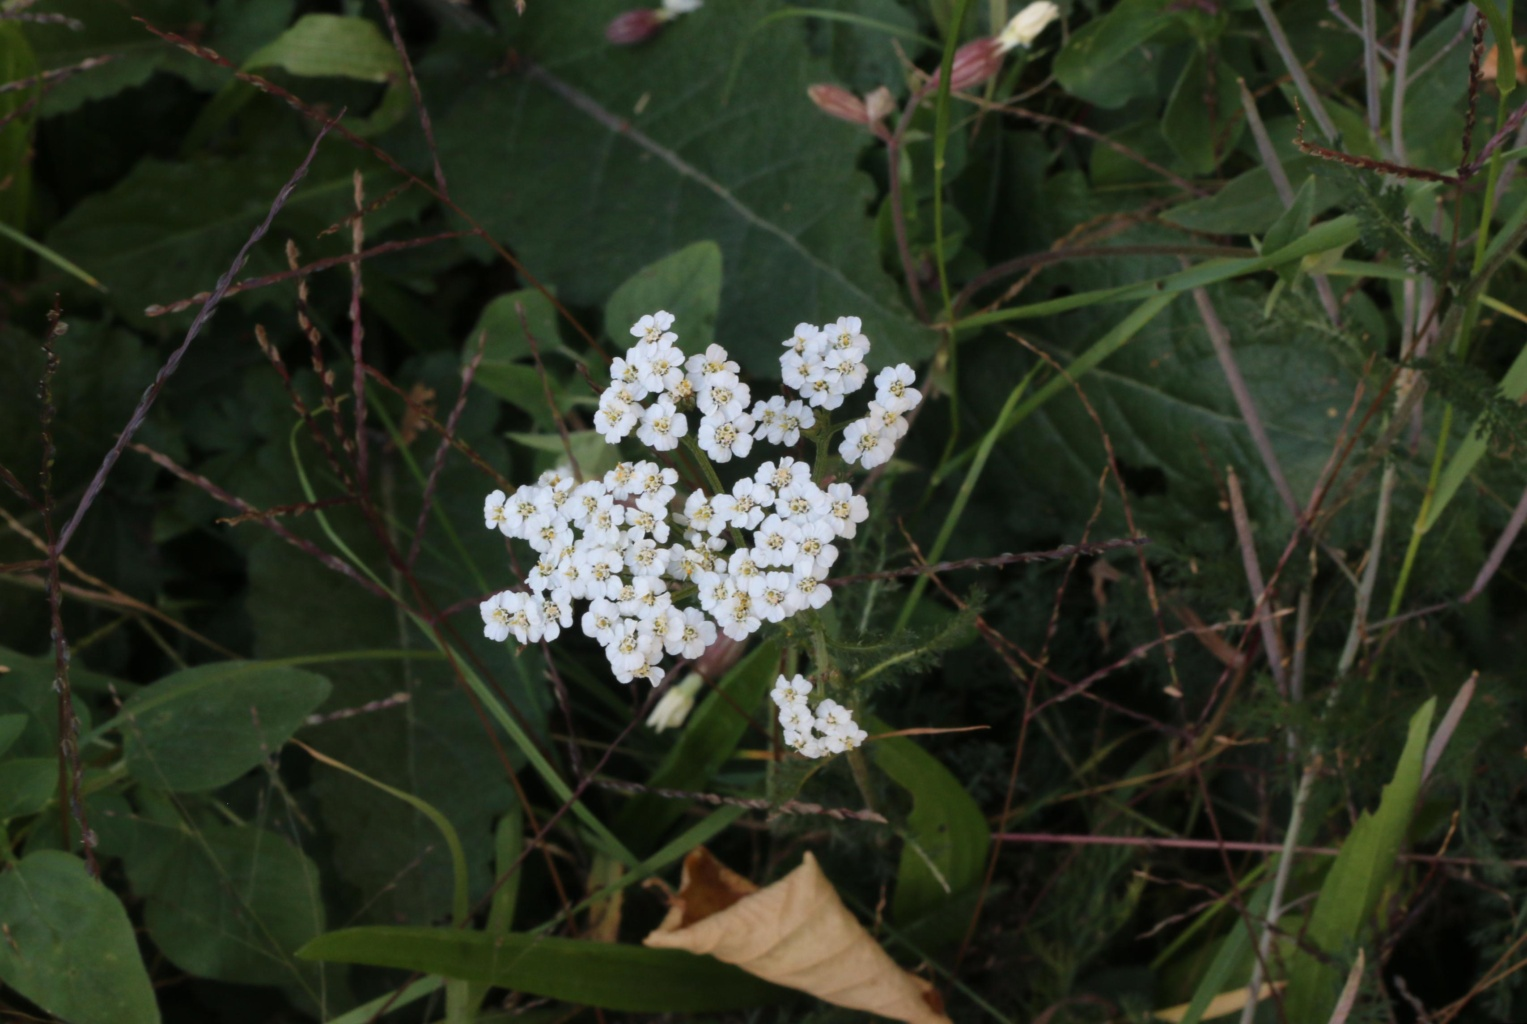

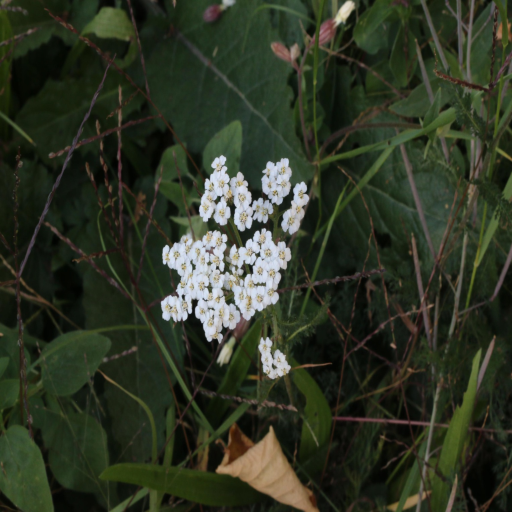

In [20]:
test = cv.imread("/content/PyNET-Bokeh/ebb_dataset/train/original/100.jpg")
cv2_imshow(test)
resized = cv.resize(test, (img_h,img_w), interpolation = cv.INTER_AREA)
cv2_imshow(resized)

# **Defining the Data Loader Class**

---



In [21]:
class DataLoader:
  def __init__(self, image_fold):
    self.images_list = []
    self.image_fold = image_fold


  def loader(self): 

    for sample in os.listdir(self.image_fold):
      try:
        #print(self.image_fold)
        #print(sample)
        sample_path = os.path.join(self.image_fold, sample)
        #print(sample_path)
        train_img = cv.imread(sample_path, cv.COLOR_BGR2RGB)
        #print("THIS")
        train_img = cv.resize(train_img, (img_h,img_w), interpolation = cv.INTER_AREA)#resize
        #print("world")
        train_img = np.array(train_img)
        train_img = train_img.astype('float32')
        
        train_img = train_img/255
        #print("hi")
        self.images_list.append(train_img)
      
      except:
        continue

    return self.images_list


# **Calling Instances of the Data Loader Class for Creating loader for testing and training**

---



In [22]:
train_x = DataLoader('/content/PyNET-Bokeh/ebb_dataset/train/original')
train_y = DataLoader('/content/PyNET-Bokeh/ebb_dataset/train/bokeh')

train_original = train_x.loader()
train_bokh = train_y.loader()

In [23]:
test_x = DataLoader('/content/PyNET-Bokeh/ebb_dataset/test/original')
test_y = DataLoader('/content/PyNET-Bokeh/ebb_dataset/test/bokeh')

test_original = test_x.loader()
test_bokeh = test_y.loader()

# **Defining the Model**

---



In [24]:
def _conv_multi_block(input, max_size, num_maps, instance_norm):

    conv_3a = _conv_layer(input, num_maps, 3, 1, relu=True, instance_norm=instance_norm)
    conv_3b = _conv_layer(conv_3a, num_maps, 3, 1, relu=True, instance_norm=instance_norm)

    output_tensor = conv_3b

    if max_size >= 5:

        conv_5a = _conv_layer(input, num_maps, 5, 1, relu=True, instance_norm=instance_norm)
        conv_5b = _conv_layer(conv_5a, num_maps, 5, 1, relu=True, instance_norm=instance_norm)

        output_tensor = stack(output_tensor, conv_5b)

    if max_size >= 7:

        conv_7a = _conv_layer(input, num_maps, 7, 1, relu=True, instance_norm=instance_norm)
        conv_7b = _conv_layer(conv_7a, num_maps, 7, 1, relu=True, instance_norm=instance_norm)

        output_tensor = stack(output_tensor, conv_7b)

    if max_size >= 9:

        conv_9a = _conv_layer(input, num_maps, 9, 1, relu=True, instance_norm=instance_norm)
        conv_9b = _conv_layer(conv_9a, num_maps, 9, 1, relu=True, instance_norm=instance_norm)

        output_tensor = stack(output_tensor, conv_9b)

    return output_tensor


def stack(x, y):
    return tf.concat([x, y], 3)


def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def leaky_relu(x, alpha=0.2):
    return tf.maximum(alpha * x, x)


def _conv_layer(net, num_filters, filter_size, strides, relu=True, instance_norm=False, padding='SAME'):

    weights_init = _conv_init_vars(net, num_filters, filter_size)
    strides_shape = [1, strides, strides, 1]
    bias = tf.Variable(tf.constant(0.01, shape=[num_filters]))

    net = tf.nn.conv2d(net, weights_init, strides_shape, padding=padding) + bias

    if instance_norm:
        net = _instance_norm(net)

    if relu:
        net = leaky_relu(net)

    return net


def _instance_norm(net):

    batch, rows, cols, channels = [i for i in net.get_shape()]
    var_shape = [channels]

    mu, sigma_sq = tf.compat.v1.nn.moments(net, [1,2], keep_dims=True)
    shift = tf.Variable(tf.zeros(var_shape))
    scale = tf.Variable(tf.ones(var_shape))

    epsilon = 1e-3
    normalized = (net-mu)/(sigma_sq + epsilon)**(.5)

    return scale * normalized + shift


def _conv_init_vars(net, out_channels, filter_size, transpose=False):

    _, rows, cols, in_channels = [i for i in net.get_shape()]

    if not transpose:
        weights_shape = [filter_size, filter_size, in_channels, out_channels]
    else:
        weights_shape = [filter_size, filter_size, out_channels, in_channels]

    weights_init = tf.Variable(tf.compat.v1.truncated_normal(weights_shape, stddev=0.01, seed=1), dtype=tf.float32)
    return weights_init


def _conv_tranpose_layer(net, num_filters, filter_size, strides):
    weights_init = _conv_init_vars(net, num_filters, filter_size, transpose=True)

    net_shape = tf.shape(net)
    tf_shape = tf.stack([net_shape[0], net_shape[1] * strides, net_shape[2] * strides, num_filters])

    strides_shape = [1, strides, strides, 1]
    net = tf.nn.conv2d_transpose(net, weights_init, tf_shape, strides_shape, padding='SAME')

    return leaky_relu(net)


def max_pool(x, n):
    return tf.nn.max_pool(x, ksize=[1, n, n, 1], strides=[1, n, n, 1], padding='VALID')

In [25]:
inputs = tf.keras.Input(shape=(512,512,3), batch_size = 20)
instance_norm = True
instance_norm_level_1=False
# Note: the paper uses a different layer naming scheme.
# In this code, layer N corresponds to layer N+2 from the article.

# -----------------------------------------
# Space-to-depth layer

space2depth_l0 = tf.nn.space_to_depth(inputs, 2)                                         # 512 -> 256

# -----------------------------------------
# Downsampling layers

conv_l1_d1 = _conv_multi_block(space2depth_l0, 3, num_maps=32, instance_norm=False)     # 256 -> 256
pool1 = max_pool(conv_l1_d1, 2)                                                         # 256 -> 128

conv_l2_d1 = _conv_multi_block(pool1, 3, num_maps=64, instance_norm=instance_norm)      # 128 -> 128
pool2 = max_pool(conv_l2_d1, 2)                                                         # 128 -> 64

conv_l3_d1 = _conv_multi_block(pool2, 3, num_maps=128, instance_norm=instance_norm)     # 64 -> 64
pool3 = max_pool(conv_l3_d1, 2)                                                         # 64 -> 32

conv_l4_d1 = _conv_multi_block(pool3, 3, num_maps=256, instance_norm=instance_norm)     # 32 -> 32
pool4 = max_pool(conv_l4_d1, 2)                                                         # 32 -> 16

# -----------------------------------------
# Processing: Level 5,  Input size: 16 x 16

conv_l5_d1 = _conv_multi_block(pool4, 3, num_maps=512, instance_norm=instance_norm)
conv_l5_d2 = _conv_multi_block(conv_l5_d1, 3, num_maps=512, instance_norm=instance_norm) + conv_l5_d1
conv_l5_d3 = _conv_multi_block(conv_l5_d2, 3, num_maps=512, instance_norm=instance_norm) + conv_l5_d2
conv_l5_d4 = _conv_multi_block(conv_l5_d3, 3, num_maps=512, instance_norm=instance_norm)

conv_t4a = _conv_tranpose_layer(conv_l5_d4, 256, 3, 2)      # 16 -> 32
conv_t4b = _conv_tranpose_layer(conv_l5_d4, 256, 3, 2)      # 16 -> 32

# -> Output: Level 5

conv_l5_out = _conv_layer(conv_l5_d4, 3, 3, 1, relu=False, instance_norm=False)
output_l5 = tf.nn.tanh(conv_l5_out) * 0.58 + 0.5

# -----------------------------------------
# Processing: Level 4,  Input size: 32 x 32

conv_l4_d2 = stack(conv_l4_d1, conv_t4a)
conv_l4_d3 = _conv_multi_block(conv_l4_d2, 3, num_maps=256, instance_norm=instance_norm)
conv_l4_d4 = _conv_multi_block(conv_l4_d3, 3, num_maps=256, instance_norm=instance_norm) + conv_l4_d3
conv_l4_d5 = _conv_multi_block(conv_l4_d4, 3, num_maps=256, instance_norm=instance_norm) + conv_l4_d4
conv_l4_d6 = stack(_conv_multi_block(conv_l4_d5, 3, num_maps=256, instance_norm=instance_norm), conv_t4b)

conv_l4_d7 = _conv_multi_block(conv_l4_d6, 3, num_maps=256, instance_norm=instance_norm)

conv_t3a = _conv_tranpose_layer(conv_l4_d7, 128, 3, 2)      # 32 -> 64
conv_t3b = _conv_tranpose_layer(conv_l4_d7, 128, 3, 2)      # 32 -> 64

# -> Output: Level 4

conv_l4_out = _conv_layer(conv_l4_d7, 3, 3, 1, relu=False, instance_norm=False)
output_l4 = tf.nn.tanh(conv_l4_out) * 0.58 + 0.5

# -----------------------------------------
# Processing: Level 3,  Input size: 64 x 64

conv_l3_d2 = stack(conv_l3_d1, conv_t3a)
conv_l3_d3 = _conv_multi_block(conv_l3_d2, 5, num_maps=128, instance_norm=instance_norm) + conv_l3_d2
conv_l3_d4 = _conv_multi_block(conv_l3_d3, 5, num_maps=128, instance_norm=instance_norm) + conv_l3_d3
conv_l3_d5 = _conv_multi_block(conv_l3_d4, 5, num_maps=128, instance_norm=instance_norm) + conv_l3_d4
conv_l3_d6 = stack(_conv_multi_block(conv_l3_d5, 5, num_maps=128, instance_norm=instance_norm), conv_l3_d1)
conv_l3_d7 = stack(conv_l3_d6, conv_t3b)

conv_l3_d8 = _conv_multi_block(conv_l3_d7, 3, num_maps=128, instance_norm=instance_norm)

conv_t2a = _conv_tranpose_layer(conv_l3_d8, 64, 3, 2)       # 64 -> 128
conv_t2b = _conv_tranpose_layer(conv_l3_d8, 64, 3, 2)       # 64 -> 128

# -> Output: Level 3

conv_l3_out = _conv_layer(conv_l3_d8, 3, 3, 1, relu=False, instance_norm=False)
output_l3 = tf.nn.tanh(conv_l3_out) * 0.58 + 0.5

# -------------------------------------------
# Processing: Level 2,  Input size: 128 x 128

conv_l2_d2 = stack(conv_l2_d1, conv_t2a)
conv_l2_d3 = stack(_conv_multi_block(conv_l2_d2, 5, num_maps=64, instance_norm=instance_norm), conv_l2_d1)

conv_l2_d4 = _conv_multi_block(conv_l2_d3, 7, num_maps=64, instance_norm=instance_norm) + conv_l2_d3
conv_l2_d5 = _conv_multi_block(conv_l2_d4, 7, num_maps=64, instance_norm=instance_norm) + conv_l2_d4
conv_l2_d6 = _conv_multi_block(conv_l2_d5, 7, num_maps=64, instance_norm=instance_norm) + conv_l2_d5
conv_l2_d7 = stack(_conv_multi_block(conv_l2_d6, 7, num_maps=64, instance_norm=instance_norm), conv_l2_d1)

conv_l2_d8 = stack(_conv_multi_block(conv_l2_d7, 5, num_maps=64, instance_norm=instance_norm), conv_t2b)
conv_l2_d9 = _conv_multi_block(conv_l2_d8, 3, num_maps=64, instance_norm=instance_norm)

conv_t1a = _conv_tranpose_layer(conv_l2_d9, 32, 3, 2)       # 128 -> 256
conv_t1b = _conv_tranpose_layer(conv_l2_d9, 32, 3, 2)       # 128 -> 256

# -> Output: Level 2

conv_l2_out = _conv_layer(conv_l2_d9, 3, 3, 1, relu=False, instance_norm=False)
output_l2 = tf.nn.tanh(conv_l2_out) * 0.58 + 0.5

# -------------------------------------------
# Processing: Level 1,  Input size: 256 x 256

conv_l1_d2 = stack(conv_l1_d1, conv_t1a)
conv_l1_d3 = stack(_conv_multi_block(conv_l1_d2, 5, num_maps=32, instance_norm=False), conv_l1_d1)

conv_l1_d4 = _conv_multi_block(conv_l1_d3, 7, num_maps=32, instance_norm=False)

conv_l1_d5 = _conv_multi_block(conv_l1_d4, 9, num_maps=32, instance_norm=instance_norm_level_1)
conv_l1_d6 = _conv_multi_block(conv_l1_d5, 9, num_maps=32, instance_norm=instance_norm_level_1) + conv_l1_d5
conv_l1_d7 = _conv_multi_block(conv_l1_d6, 9, num_maps=32, instance_norm=instance_norm_level_1) + conv_l1_d6
conv_l1_d8 = _conv_multi_block(conv_l1_d7, 9, num_maps=32, instance_norm=instance_norm_level_1) + conv_l1_d7

conv_l1_d9 = stack(_conv_multi_block(conv_l1_d8, 7, num_maps=32, instance_norm=False), conv_l1_d1)

conv_l1_d10 = stack(_conv_multi_block(conv_l1_d9, 5, num_maps=32, instance_norm=False), conv_t1b)
conv_l1_d11 = stack(conv_l1_d10, conv_l1_d1)

conv_l1_d12 = _conv_multi_block(conv_l1_d11, 3, num_maps=32, instance_norm=False)

# -> Output: Level 1

conv_l1_out = _conv_layer(conv_l1_d12, 3, 3, 1, relu=False, instance_norm=False)
output_l1 = tf.nn.tanh(conv_l1_out) * 0.58 + 0.5

# ----------------------------------------------------------
# Processing: Level 0 (x2 upscaling),  Input size: 256 x 256

conv_l0 = _conv_tranpose_layer(conv_l1_d12, 8, 3, 2)        # 256 -> 512
conv_l0_out = _conv_layer(conv_l0, 3, 3, 1, relu=False, instance_norm=False)
output_l0 = tf.nn.tanh(conv_l0_out) * 0.58 + 0.5

# ----------------------------------------------------------
# Processing: Level Up (x4 upscaling),  Input size: 512 x 512

conv_l_up = _conv_tranpose_layer(conv_l0_out, 3, 3, 2)  # 512 -> 1024
conv_l_up_out = _conv_layer(conv_l_up, 3, 3, 1, relu=False, instance_norm=False)

output_l_up = tf.nn.tanh(conv_l_up_out) * 0.58 + 0.5



In [ ]:
import tensorflow 
from tensorflow.keras.models import Model
from tensorflow.keras import Input
inputs = Input(shape=(512,512,3), batch_size = 10)
out = output_l0
model = Model(inputs = inputs, outputs = out)

# **Compiling the Model**

---



In [ ]:
model.compile(loss =tf.keras.losses.MeanSquaredError(), optimizer = 'adam',metrics=['accuracy'] )

# **Training the Model**

---



In [ ]:
model.fit(train_original,train_bokh,validation_data = (test_original, test_bokeh),epochs = 5,batch_size = batch_size)